In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp
from utils import gp, Gaussian
import matplotlib.pyplot as plt
import jax

In [2]:
cp_terms = pd.read_csv('data/cpshake_gt.csv', skiprows=1, parse_dates=["Week"])
pt_shake = pd.read_csv("data/protein_shak_gt.csv", skiprows=1, parse_dates=["Week"])
time = jnp.linspace(0, len(cp_terms)-1, len(cp_terms))[:, None]
pt_shake.columns = [col.replace(": (United States)", "") for col in pt_shake.columns]
cp_terms.columns = [col.replace(": (United States)", "") for col in cp_terms.columns]
cp_terms['Time'] = time
pt_shake['Time'] = time

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [3]:
time_plus = jnp.linspace(0, len(cp_terms)+30, len(cp_terms)+31)[:, None]

In [4]:
cp_terms.head()

,Week,Core Power Protein,protein shake core power,Time
0,2019-12-29,17,10,0.0
1,2020-01-05,17,8,1.0
2,2020-01-12,21,8,2.0
3,2020-01-19,20,10,3.0
4,2020-01-26,19,6,4.0


In [5]:
def plot_shaded(x, gp, color="gray", alpha=0.5, ax = None, name=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    ax.fill_between(x[:, 0], gp(x).mu - 2*gp(x).std, gp(x).mu + 2*gp(x).std, color=color, alpha=alpha)
    ax.plot(x, gp(x).mu, color="black")
    ax.plot(x, gp(x).mu - 2*gp(x).std, color="black", linestyle="--")
    ax.plot(x, gp(x).mu + 2*gp(x).std, color="black", linestyle="--")
    ax.legend(["Mean", "Lower 95% CI", "Upper 95% CI"])
    if name is not None:
        ax.set_ylabel(name)
    return ax

In [12]:
long_term_trend = gp.SEKernel(length_scale=52*6, theta=30)
yearly_periodic = gp.PeriodicKernel(length_scale=1, period=52.18, theta=1)*gp.SEKernel(length_scale=66, theta=.15)
quarterly_periodic = gp.PeriodicKernel(length_scale=1, period=13, theta=1)*gp.SEKernel(length_scale=20, theta=.03)
yl_trend = gp.RQKernel(length_scale=52, theta=5, alpha=3)
#qt_trend = gp.RQKernel(length_scale=13, alpha=1.4, theta=1)
month_trend = gp.SEKernel(length_scale=5, theta=.1)
noise = gp.WhiteNoiseKernel(2)*gp.SEKernel(length_scale=2, theta=1)
walk = gp.WeinerKernel(shift=-1, theta = .1)*gp.SEKernel(length_scale=2, theta=2)
clean_cp = cp_terms
y = jnp.array(clean_cp["Core Power Protein"])
time_clean = jnp.array(clean_cp["Time"])[:, None]
y_mean = jnp.mean(y)

constant_mean = lambda x: jnp.ones(len(x))*y_mean
seasonal_trend = (yearly_periodic + quarterly_periodic)*(long_term_trend+yl_trend)

gp_search = gp.GaussianProcess(constant_mean, seasonal_trend + noise + long_term_trend + yl_trend)

samples = gp_search(time_plus).sample(jax.random.PRNGKey(0), 3)
conditioned_search = gp_search.condition(time_clean[:-50], y[:-50], 3)
conditioned_samples = conditioned_search(time_plus).sample(jax.random.PRNGKey(0), 10)

<Axes: >

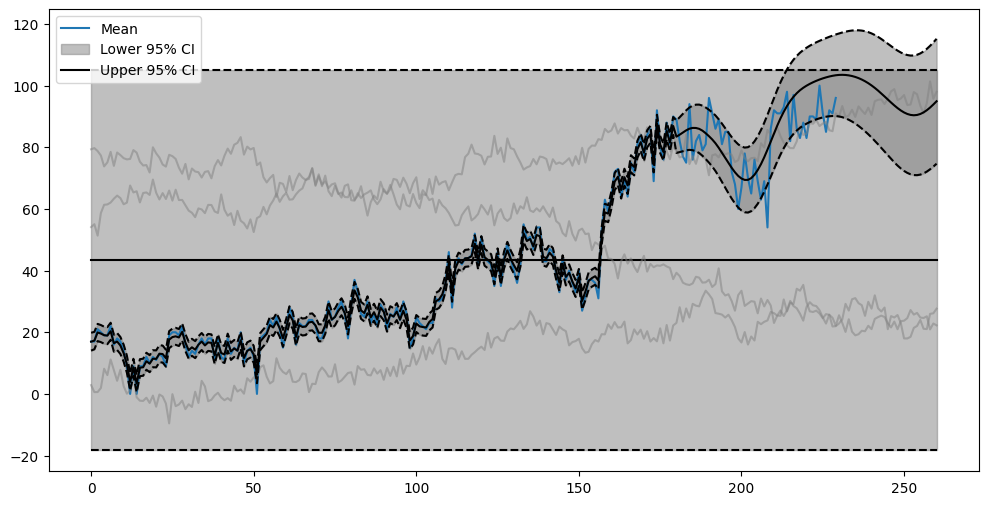

In [13]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(time_clean, y)
plot_shaded(time_plus, gp_search, ax=ax)
ax.plot(time_plus, samples.T, color="gray", alpha=0.5)
plot_shaded(time_plus, conditioned_search, ax=ax)


In [14]:
def plot_shaded(x, gp, color="gray", alpha=0.5, ax = None, name=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    ax.fill_between(x[:, 0], gp(x).mu - 2*gp(x).std, gp(x).mu + 2*gp(x).std, color=color, alpha=alpha)
    ax.plot(x, gp(x).mu, color="black")
    ax.plot(x, gp(x).mu - 2*gp(x).std, color="black", linestyle="--")
    ax.plot(x, gp(x).mu + 2*gp(x).std, color="black", linestyle="--")
    ax.legend(["Mean", "Lower 95% CI", "Upper 95% CI"])
    if name is not None:
        ax.set_ylabel(name)
    return ax

In [15]:
zero_mean = lambda x: jnp.zeros_like(x[..., 0])
yearly_periodic_gp = conditioned_search.project(seasonal_trend, zero_mean)
quarterly_periodic_gp = conditioned_search.project(quarterly_periodic, zero_mean)
month_trend_gp = conditioned_search.project(month_trend, zero_mean)
#qt_trend_gp = conditioned_search.project(qt_trend, zero_mean)
linear_trend_gp = conditioned_search.project(long_term_trend, constant_mean)
yl_trend_gp = conditioned_search.project(yl_trend, zero_mean)

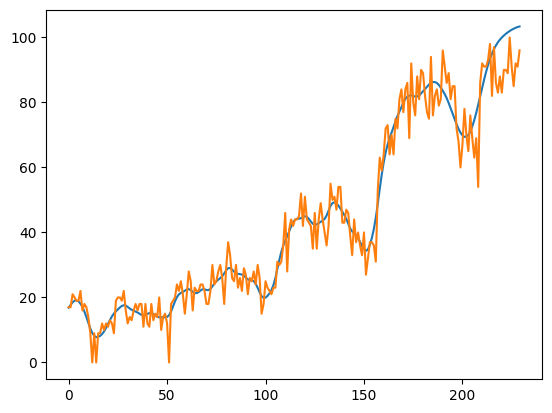

In [16]:
plt.plot(yearly_periodic_gp(time).mu+linear_trend_gp(time).mu+yl_trend_gp(time).mu)
plt.plot(time[:, 0], y)

<Axes: ylabel='Qrt Periodic'>

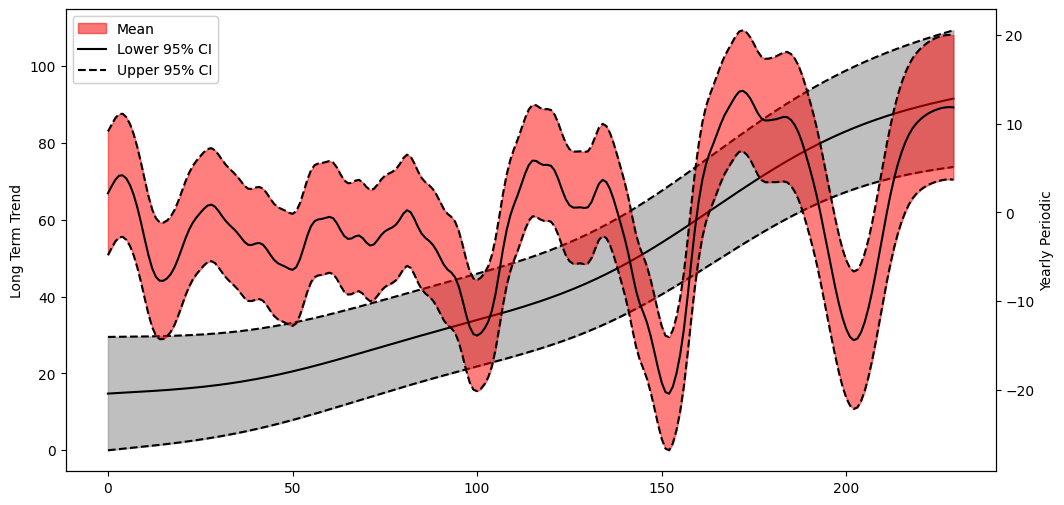

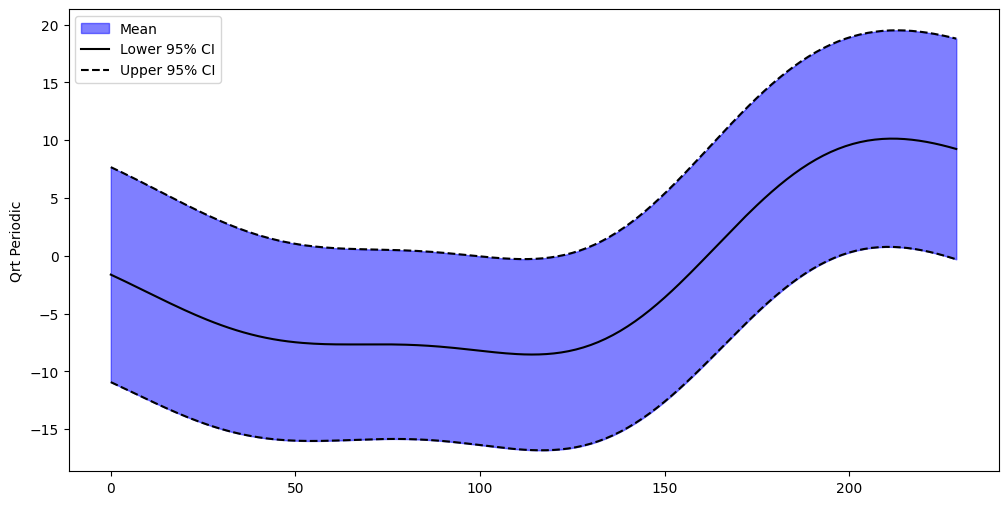

In [17]:
ax=plot_shaded(time, linear_trend_gp + yl_trend_gp, name="Long Term Trend")
ax1 = ax.twinx()
plot_shaded(time, yearly_periodic_gp, ax=ax1, color="red", name="Yearly Periodic")

plot_shaded(time, yl_trend_gp, color="blue", name="Qrt Periodic")